In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
!pip install transformers
from transformers import TFRobertaForSequenceClassification
from transformers import RobertaTokenizer


     |████████████████████████████████| 2.1MB 9.1MB/s 
     |████████████████████████████████| 901kB 51.6MB/s 
     |████████████████████████████████| 3.3MB 55.9MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("drive/MyDrive/Explo/self_labelled_data.csv", header=0, names=['Tweets', 'Label'])
print(df.head())

                                              Tweets  Label
0  मुम्बई डोंगरी रास्ते नमाज़ पढ़कर कोरोना भगाते ...      1
1  कोरोना हराना हैलॉक डाउन क्यों ज़रूरी केजीएमयू ...      1
2  सब समझते समझ सब काम कीया कोरोना वायरस जैविक बम...      1
3  कोरोना वायरस युद्ध बड़ा संकट मानकर पूरी क्षमता...      1
4  “ अप्रेल मोदी जी बजे मिनट दीपक जलाने संदेश दीप...      1


In [ ]:
df.Label = pd.Categorical(df.Label)
df['Label'] = df['Label'].cat.codes
df = df.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
train_tweets, test_tweets = train_test_split(df, random_state=91)

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_length = 128
batch_size = 32

In [ ]:
def convert_example_to_feature(review):
    return roberta_tokenizer.encode_plus(review,
                                 add_special_tokens=True,  
                                 max_length=max_length,  
                                 pad_to_max_length=True,  
                                 return_attention_mask=True,  
                                 )


In [ ]:

def map_example_to_dict(input_ids, attention_masks, label):
    return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
           }, label


In [ ]:
def encode_examples(ds, limit=-1):
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    if (limit > 0):
        ds = ds.take(limit)

    for review, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(review.decode())
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list,
                                               attention_mask_list,
                                               label_list)).map(map_example_to_dict)

In [ ]:
training_sentences_modified = tf.data.Dataset.from_tensor_slices((train_tweets['Tweets'],
                                                                  train_tweets['Label']))

testing_sentences_modified = tf.data.Dataset.from_tensor_slices((test_tweets['Tweets'],
                                                                 test_tweets['Label']))


In [ ]:

ds_train_encoded = encode_examples(training_sentences_modified).shuffle(1000).batch(batch_size)
ds_test_encoded = encode_examples(testing_sentences_modified).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
learning_rate = 2e-5
number_of_epochs = 100

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




In [ ]:
# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['acc',f1_m,precision_m, recall_m])


# fit the model
bert_history= model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.auto

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np


def plot_graphs1(H):
    plt.style.use("ggplot")
    plt.figure(figsize=((10,8)))
    plt.plot(np.arange(1, number_of_epochs+1), H.history["loss"], label="train_loss")
    plt.plot(np.arange(1, number_of_epochs+1), H.history["acc"], label="train_acc")
    plt.plot(np.arange(1, number_of_epochs+1), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("model_history1")
    plt.show()

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def plot_graphs2(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.figure(figsize=((10,8)))
    plt.plot(np.arange(1, number_of_epochs+1), H.history["f1_m"], label="F1 Score")
    plt.plot(np.arange(1, number_of_epochs+1), H.history["recall_m"], label="Recall")
    plt.plot(np.arange(1, number_of_epochs+1), H.history["precision_m"], label="Precision")
    plt.title("Other Metrics")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig("model_history2")
    plt.show()

In [ ]:
def plot_recall(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.figure(figsize=((10,8)))
    plt.plot(np.arange(1, number_of_epochs+1), H.history["recall_m"], label="Recall")
    plt.title("Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig("model_recall")
    plt.show()

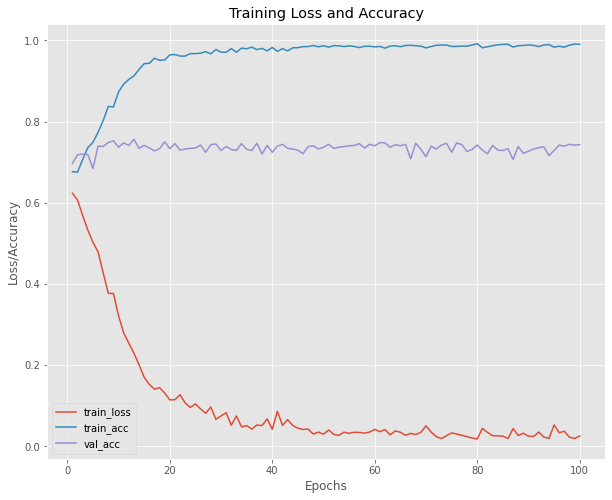

In [ ]:
plot_graphs1(bert_history)

<Figure size 432x288 with 0 Axes>

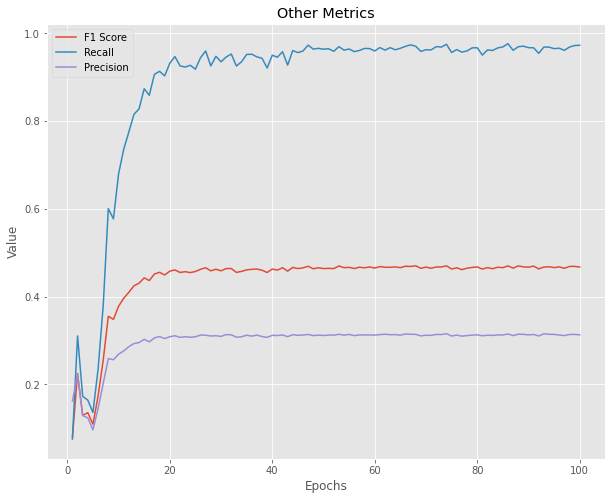

In [ ]:
plot_graphs2(bert_history)

<Figure size 432x288 with 0 Axes>

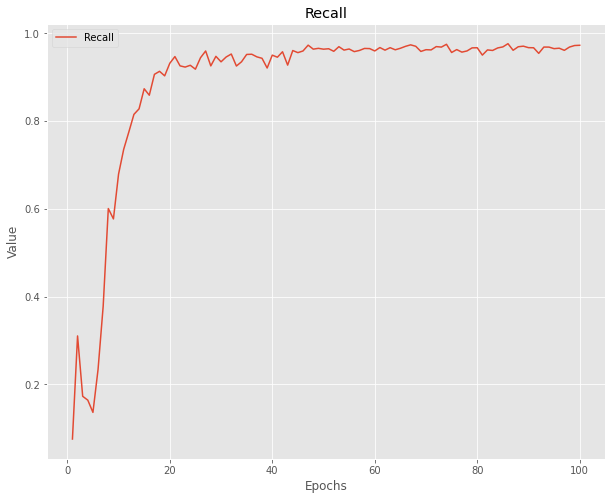

In [ ]:
plot_recall(bert_history)

In [ ]:
def plot_f1(H):
    plt.style.use("ggplot")
    plt.figure()
    ##
    plt.figure(figsize=((10,8)))
    #plt.plot([1,1.6,3])
    ##
    plt.plot(np.arange(1, number_of_epochs+1), H.history["f1_m"], label="F1 Score")
    #plt.plot(np.arange(1, number_of_epochs+1), H.history["recall_m"], label="Recall")
    #plt.plot(np.arange(1, number_of_epochs+1), H.history["precision_m"], label="Precision")
    

    plt.title("F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig("model_f1_score")
    plt.show()

<Figure size 432x288 with 0 Axes>

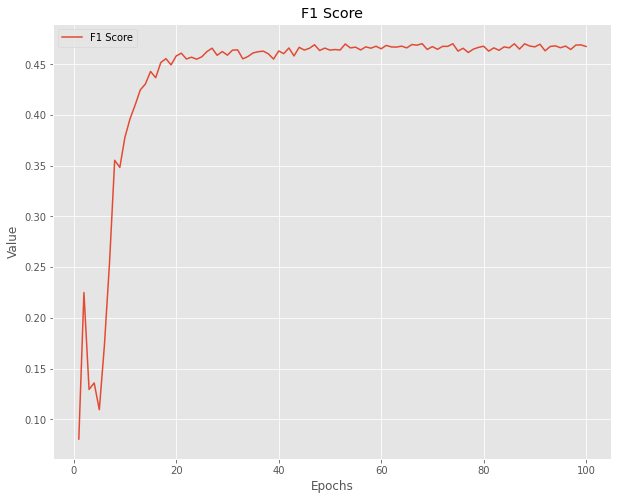

In [ ]:
plot_f1(bert_history)

In [ ]:
def plot_precision(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.figure(figsize=((10,8)))
    plt.plot(np.arange(1, number_of_epochs+1), H.history["precision_m"], label="Precision")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig("model_precision")
    plt.show()

<Figure size 432x288 with 0 Axes>

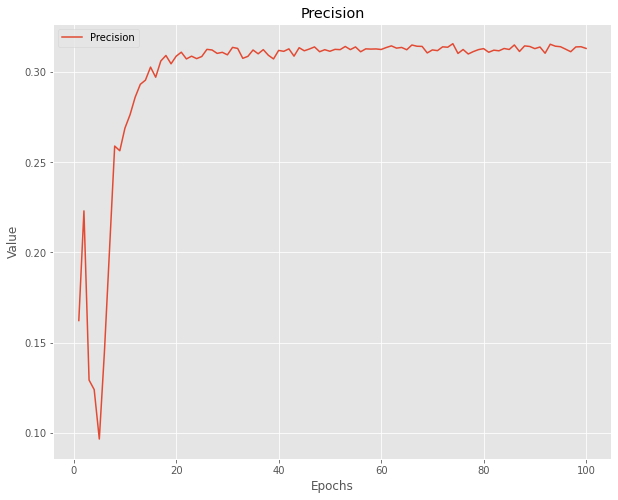

In [ ]:
plot_precision(bert_history)